In [1]:
import torch
import torch.nn as nn
import yfinance as yf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
# Set the random seed for NumPy
np.random.seed(42)

# Set the random seed for PyTorch
torch.manual_seed(42)

In [3]:
ticker = "MSFT"

live_data = yf.download(tickers=ticker, period="5y", interval="1d")

[*********************100%%**********************]  1 of 1 completed


In [4]:
def create_seq(data, seq_len):
    xs, trg, ys = [], [], []
    for i in range(len(data)-seq_len):
        xs.append(data[i:i+seq_len])
        trg.append(data[i+seq_len-1])
        ys.append(data[i+seq_len])

    return np.array(xs), np.array(trg), np.array(ys)

seq_len = 30
X, trg, y = create_seq(live_data['Close'].values, seq_len=seq_len)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, trg_train, trg_test, y_train, y_test = train_test_split(X, trg, y, test_size=0.3)

In [6]:
class stock_dataset(Dataset):
    def __init__(self, X, trg, y):
        super(stock_dataset, self).__init__()
        self.X = torch.from_numpy(X).float()
        self.trg = torch.from_numpy(trg).float().unsqueeze(-1)
        self.y = torch.from_numpy(y).float().unsqueeze(-1)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.trg[index], self.y[index]
    
train_dataset = stock_dataset(X_train, trg_train, y_train)
test_dataset = stock_dataset(X_test, trg_test, y_test)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)



In [7]:
# import math
# class positionalEncoding(nn.Module):
#     def __init__(self, embed_dim, maxlen=100):
#         super(positionalEncoding, self).__init__()
#         self.encoding = torch.zeros(maxlen, embed_dim)
#         position = torch.arange(0, maxlen).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
#         self.encoding[:, 0::2] = torch.sin(position * div_term)
#         self.encoding[:, 1::2] = torch.cos(position * div_term)
#         self.encoding = self.encoding.unsqueeze(0)

#     def forward(self, x):
#         seq_len = x.size(1)
#         return x + self.encoding
    

# class Transformer_Model(nn.Module):
#     def __init__(self, input_size, seq_len, n_layers, n_heads, hidden_dim, dropout=0.1):
#         super(Transformer_Model, self).__init__()
#         self.input_size = input_size
#         self.embedding = nn.Linear(self.input_size, hidden_dim)
#         self.positional_encoding = positionalEncoding(hidden_dim, maxlen=seq_len)
#         self.encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads, dim_feedforward=128, dropout=dropout)
#         self.transformer_encoder = nn.TransformerEncoder(self.encoder_layers, num_layers=n_layers)
#         self.decoder1 = nn.Linear(hidden_dim, 1)
#         self.decoder2 = nn.Linear(seq_len, 1)
        

#     def forward(self, src):
#         src = self.embedding(src)
#         src = self.positional_encoding(src)
#         src = self.transformer_encoder(src)
#         src = self.decoder1(src[:,-1,:])
#         # src = src.squeeze()
#         # src = self.decoder2(src)
#         # print(src.shape)
#         return src
        
        


In [18]:
import math

class positionalEncoding(nn.Module):
    def __init__(self, embed_dim, maxlen=100):
        super(positionalEncoding, self).__init__()
        self.encoding = torch.zeros(maxlen, embed_dim)
        position = torch.arange(0, maxlen).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        # seq_len = x.size(1)
        return x + self.encoding
    

class timeseriestransformer(nn.Module):

    def __init__(self,
                 input_size,
                 seq_len,
                 out_len,
                 hidden_dim,
                 n_layers,
                 n_heads,
                 dropout
                 ):
        super(timeseriestransformer, self).__init__()
        self.out_len = out_len

        self.encoder_inp_layer = nn.Linear(input_size, hidden_dim)
        self.decoder_inp_layer = nn.Linear(input_size, hidden_dim)
        self.linear_mapping = nn.Linear(out_len*hidden_dim, out_len)

        self.pe = positionalEncoding(hidden_dim, seq_len)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim,
                                                        nhead=n_heads,
                                                        dim_feedforward=512,
                                                        dropout=dropout,
                                                        batch_first=True)
        
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)

        self.decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_dim,
                                                        nhead=n_heads,
                                                        dim_feedforward=512,
                                                        dropout=dropout,
                                                        batch_first=True)
        
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=n_layers)


    def forward(self, src, tgt):
        src = self.encoder_inp_layer(src)
        src = self.pe(src)
        src = self.encoder(src)

        tgt = self.decoder_inp_layer(tgt)
        tgt = self.decoder(tgt=tgt, memory=src)
        # print(tgt.shape, tgt.flatten(1).shape)
        out = self.linear_mapping(tgt.flatten(1))

        return out


In [19]:
input_size = 1
out_len = 1
hidden_dim = 32
n_layers = 12
n_heads = 16
dropout = 0.2

model = timeseriestransformer(input_size=input_size,
                              seq_len=seq_len,
                              out_len=out_len,
                              hidden_dim=hidden_dim,
                              n_layers=n_layers,
                              n_heads=n_heads,
                              dropout=dropout)


In [20]:
lr = 0.01
EPOCH = 50
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model.train()
for e in range(EPOCH):
    e_loss = 0
    for i, batch in enumerate(train_loader):
        X_batch, trg_batch, y_batch = batch
        output = model(X_batch.unsqueeze(-1), trg_batch.unsqueeze(-1))
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        e_loss += loss.item()

    scheduler.step()

    print("Epoch: {} of {} ; Loss: {:.2f}".format(e+1, EPOCH, e_loss/len(train_loader)))



Epoch: 1 of 50 ; Loss: 74880.88
Epoch: 2 of 50 ; Loss: 71323.55
Epoch: 3 of 50 ; Loss: 65170.90
Epoch: 4 of 50 ; Loss: 56087.54
Epoch: 5 of 50 ; Loss: 46190.10
Epoch: 6 of 50 ; Loss: 34239.80
Epoch: 7 of 50 ; Loss: 22844.49
Epoch: 8 of 50 ; Loss: 12866.80
Epoch: 9 of 50 ; Loss: 6841.52
Epoch: 10 of 50 ; Loss: 7097.04
Epoch: 11 of 50 ; Loss: 9497.34
Epoch: 12 of 50 ; Loss: 10023.34
Epoch: 13 of 50 ; Loss: 10785.23
Epoch: 14 of 50 ; Loss: 11146.11
Epoch: 15 of 50 ; Loss: 12032.02
Epoch: 16 of 50 ; Loss: 12252.49
Epoch: 17 of 50 ; Loss: 12348.53
Epoch: 18 of 50 ; Loss: 12305.81
Epoch: 19 of 50 ; Loss: 12380.96
Epoch: 20 of 50 ; Loss: 12045.12
Epoch: 21 of 50 ; Loss: 11832.03
Epoch: 22 of 50 ; Loss: 11967.05
Epoch: 23 of 50 ; Loss: 11540.23
Epoch: 24 of 50 ; Loss: 11524.79
Epoch: 25 of 50 ; Loss: 11545.11
Epoch: 26 of 50 ; Loss: 11270.27
Epoch: 27 of 50 ; Loss: 11264.45
Epoch: 28 of 50 ; Loss: 11240.11
Epoch: 29 of 50 ; Loss: 11064.42
Epoch: 30 of 50 ; Loss: 10911.22
Epoch: 31 of 50 ; Loss

In [ ]:
X_b, trg_b, y_b = next(enumerate(test_loader))[1]


tensor(8931.4492, grad_fn=<MseLossBackward0>)
tensor(6608.8408, grad_fn=<MseLossBackward0>)


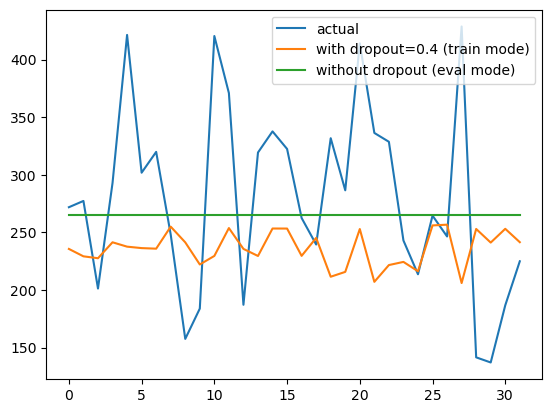

In [ ]:
model.train()
outputb1 = model(X_b.unsqueeze(-1), trg_b.unsqueeze(-1))
model.eval()
outputb2 = model(X_b.unsqueeze(-1), trg_b.unsqueeze(-1))
plt.plot(list(y_b.detach().squeeze().numpy()), label="actual")
plt.plot(list(outputb1.detach().squeeze().numpy()), label="with dropout={} (train mode)".format(dropout))
plt.plot(list(outputb2.detach().squeeze().numpy()), label="without dropout (eval mode)")

plt.legend()
# plt.plot(y_ac)
# plt.plot(y_pred)
print(criterion(outputb1, y_b))
print(criterion(outputb2, y_b))

In [ ]:
y_b.shape

torch.Size([32, 1])

In [ ]:
model.eval()

y_ac = []
y_pred = []
with torch.no_grad():
    for batch in test_loader:
        xt, trgt, yt = batch
        ypt = model(xt.unsqueeze(-1), trgt.unsqueeze(-1))
        y_ac.extend(yt.numpy().flatten())
        y_pred.extend(ypt.numpy().flatten())